# <a> Data Science in Projects - Project 1: Price Prediction</a>

## Let's Data - Data Science Journey

*By Reginaldo Jr - <a>reginaldojr@yahoo.com</a>*

## imports and Configuratins

In [2]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import xgboost as xgb

from IPython.display import clear_output
from matplotlib import pyplot as plt
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler
from sklearn.feature_selection import SelectFdr, SelectFpr, SelectFwe, f_classif
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import (
    LogisticRegression, 
    PassiveAggressiveClassifier, 
    SGDClassifier, 
    RidgeClassifier    
)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    ExtraTreesClassifier, 
    BaggingClassifier
)
from xgboost import XGBClassifier

sns.set_style("darkgrid")

warnings.filterwarnings("ignore")

pd.set_option("display.float_format", None)
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

## Data

In [3]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## EDA

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [7]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

<AxesSubplot:xlabel='Outcome', ylabel='count'>

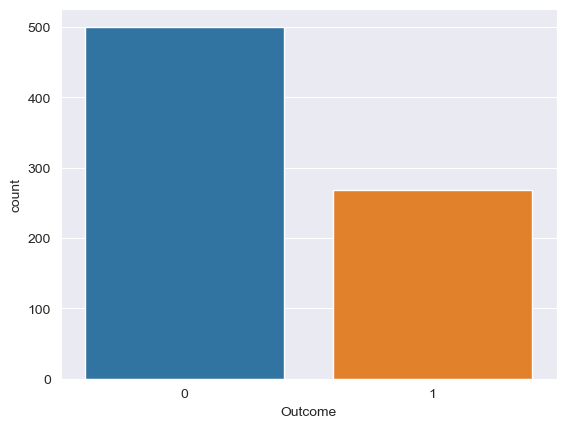

In [8]:
sns.countplot(data=df, x="Outcome")

In [9]:
df["Outcome"].value_counts(normalize=True) * 100

0    65.104167
1    34.895833
Name: Outcome, dtype: float64

In [10]:
numerical_cols = df.describe().columns[:len(df.describe().columns)-1]
numerical_cols, len(numerical_cols)

(Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age'],
       dtype='object'),
 8)

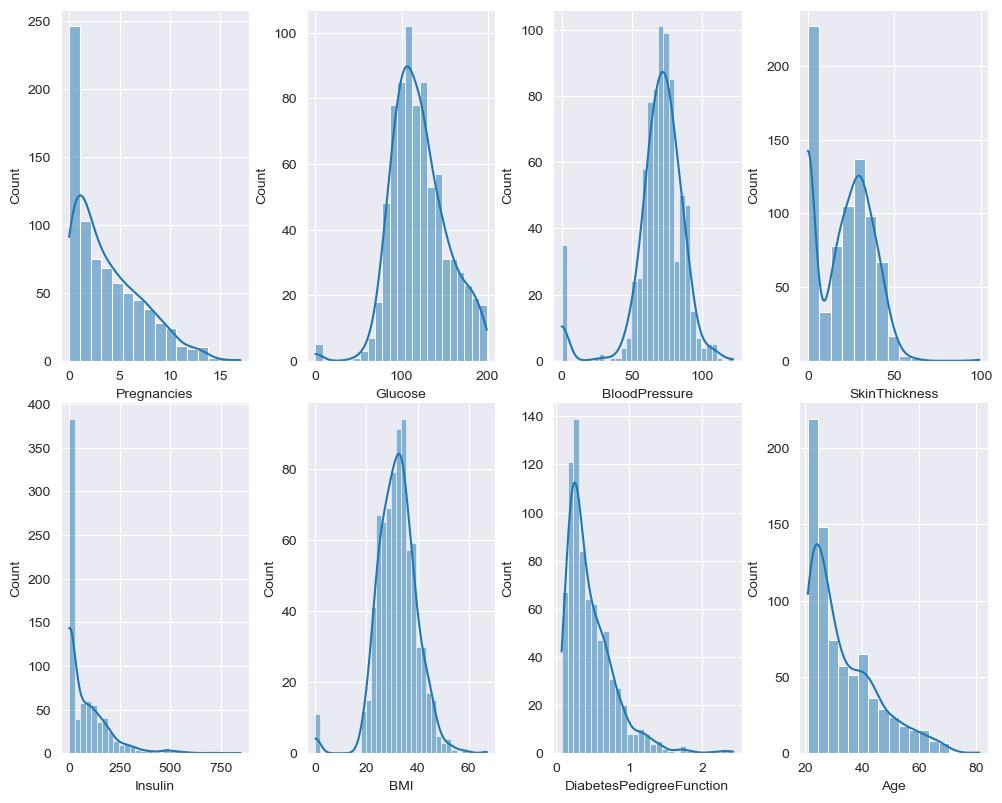

In [11]:
fig, graph = plt.subplots(2,4, figsize=(10,8))

plt.tight_layout()
for i,col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, ax=graph[i//4][i%4], kde=True)

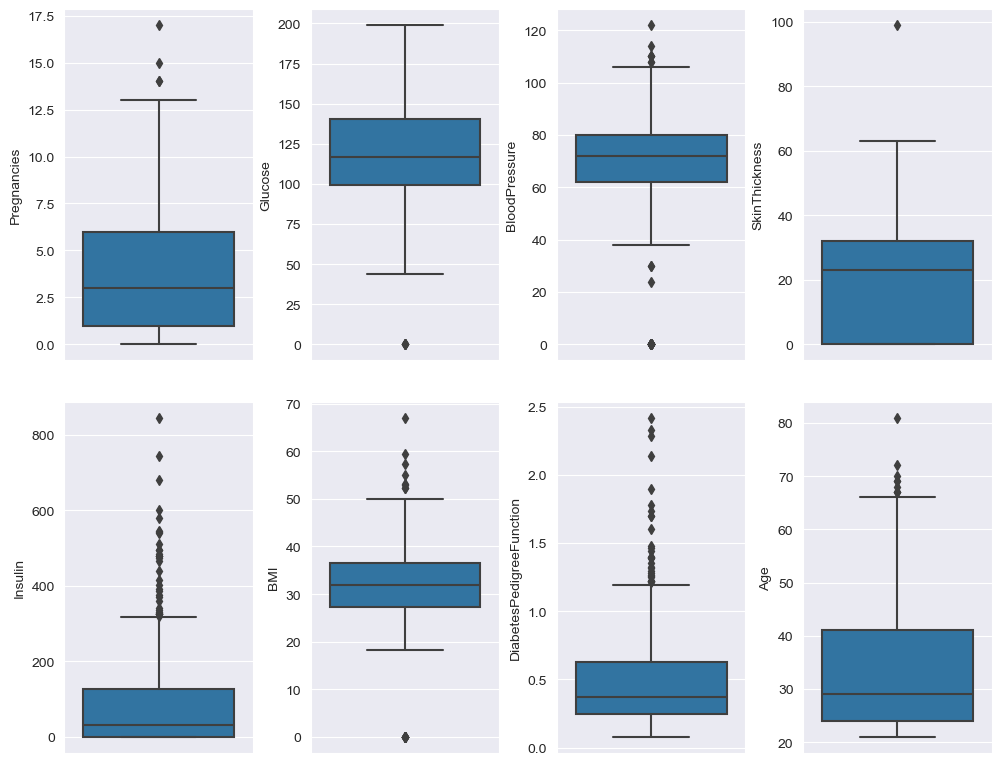

In [12]:
fig, graph = plt.subplots(2,4, figsize=(10,8))

plt.tight_layout()
for i,col in enumerate(numerical_cols):
    sns.boxplot(data=df, y=col, ax=graph[i//4][i%4])

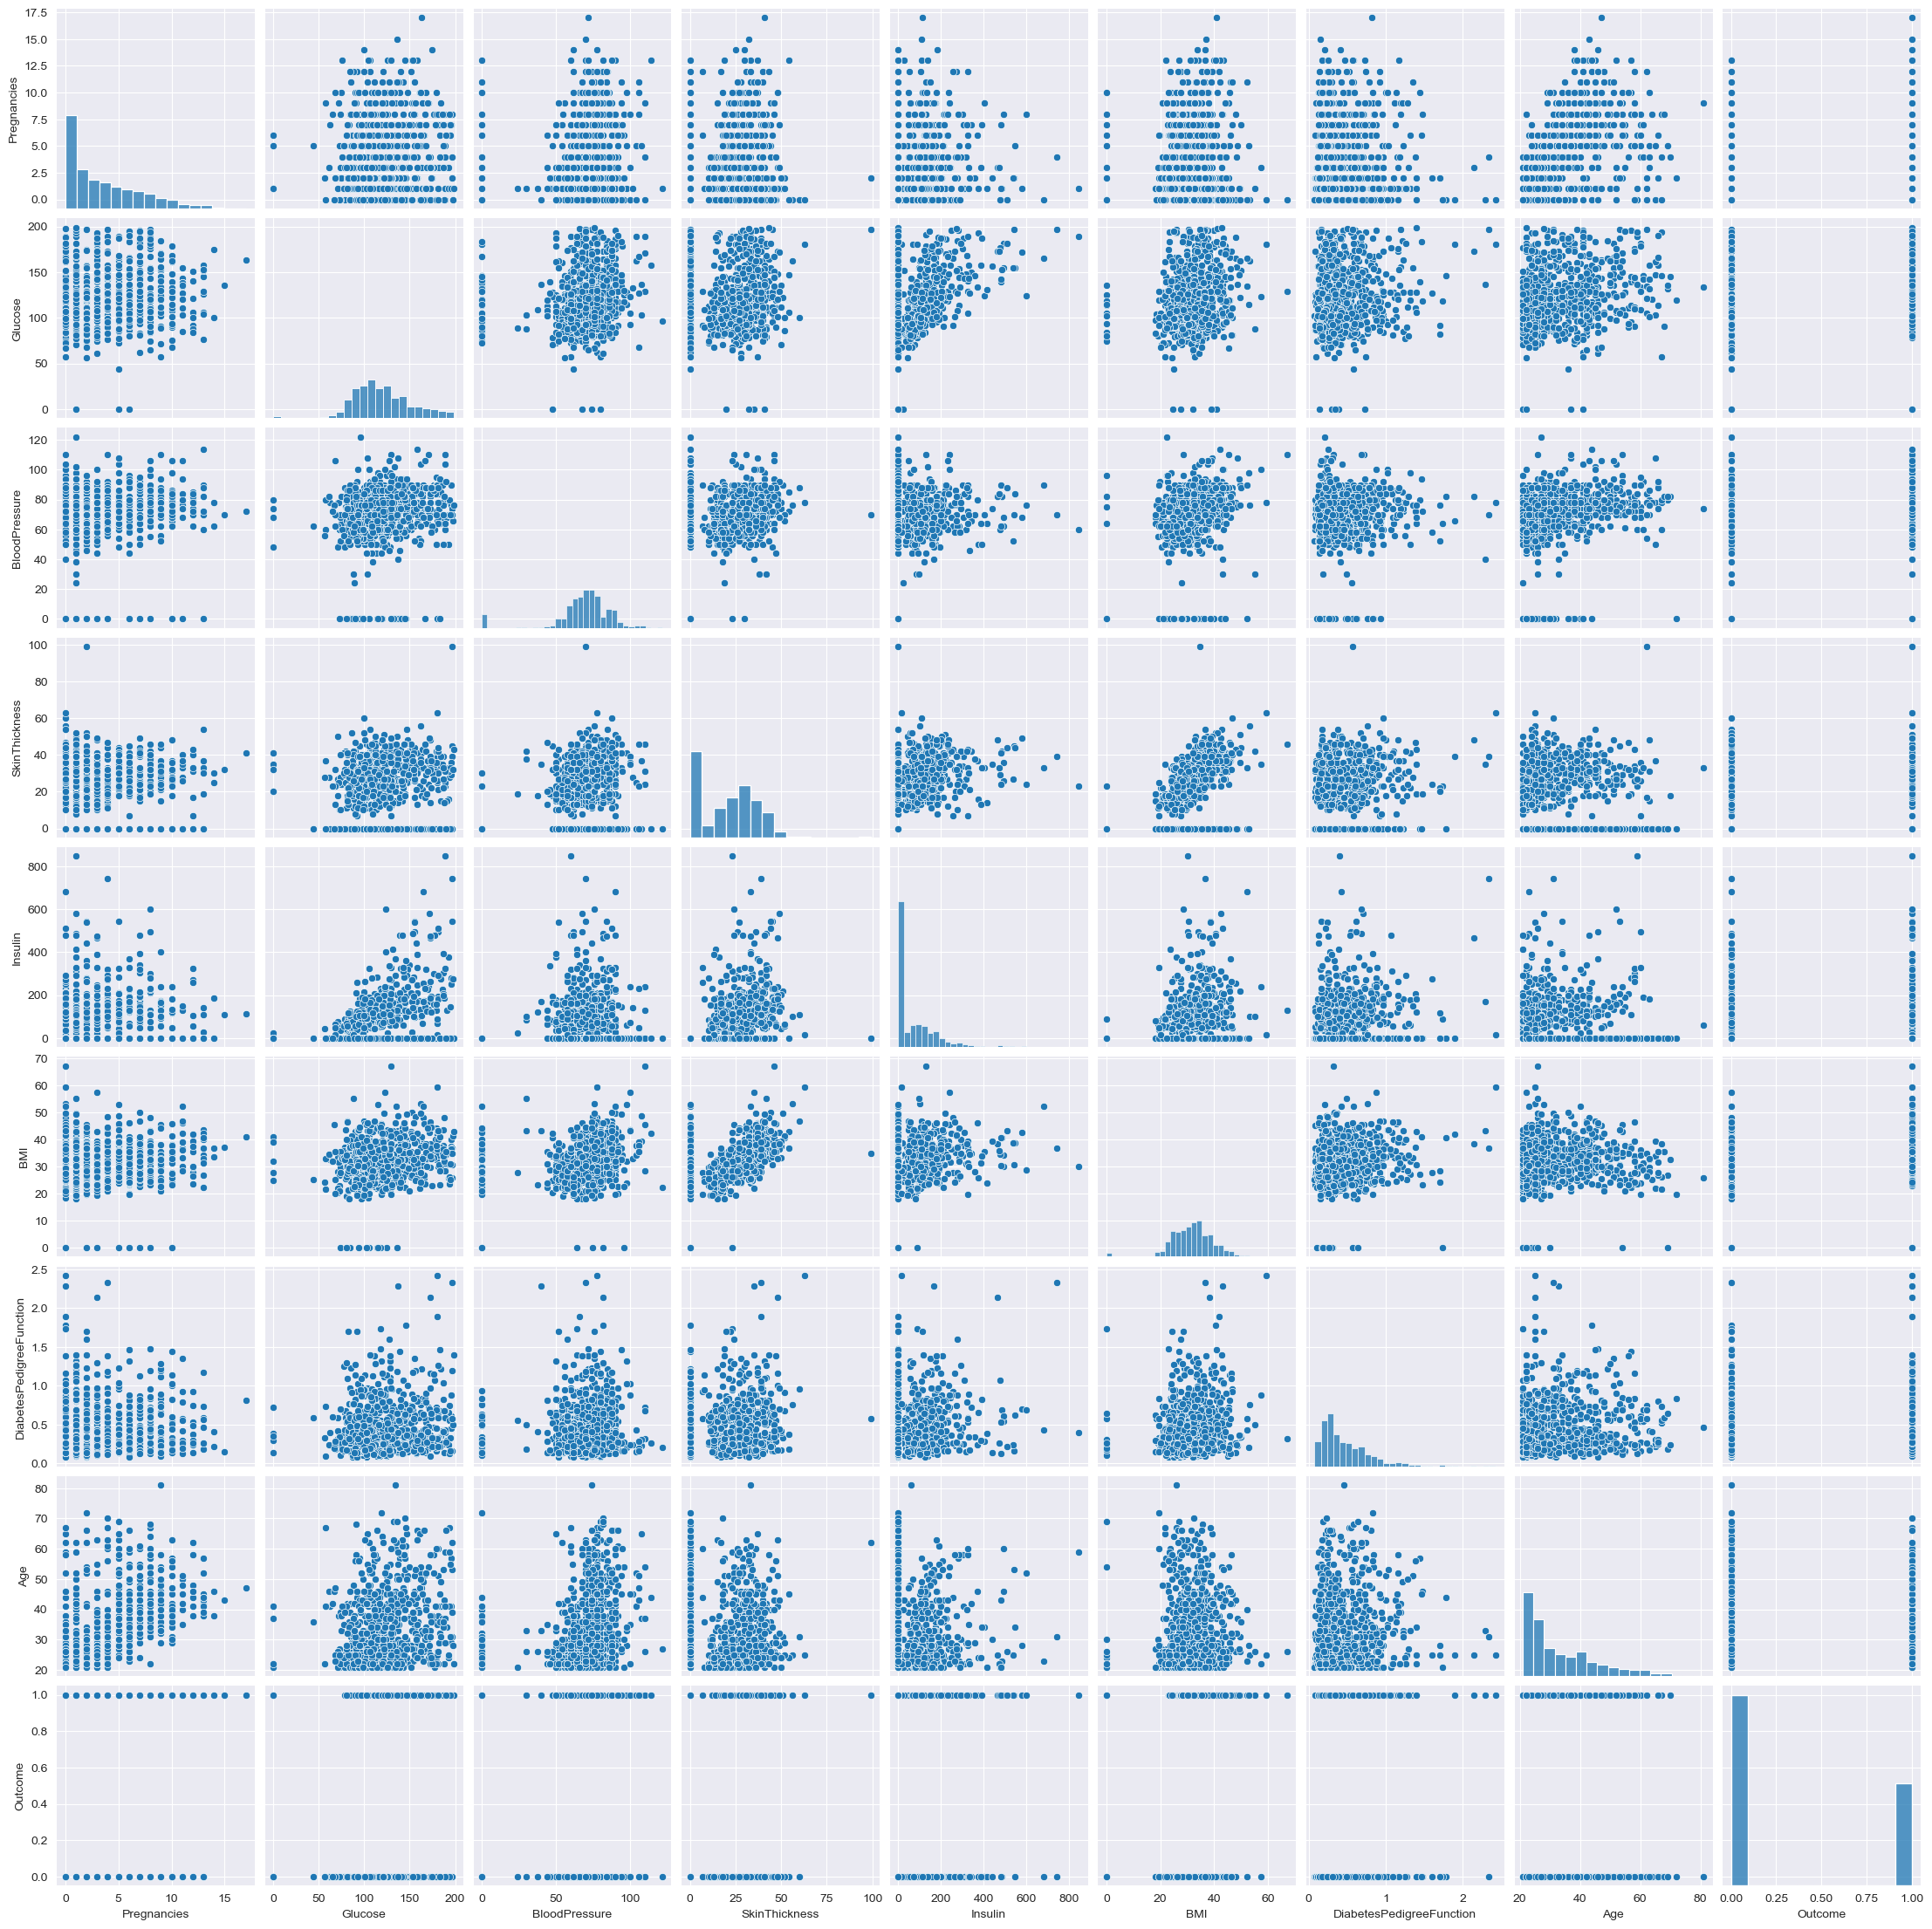

In [13]:
sns.pairplot(data=df)

## Separation of Variables

In [91]:
X = df.drop(["Outcome"], axis=1)
y = df[["Outcome"]]

In [92]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [93]:
y.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


## Base separation

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.2, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614, 1), (154, 1))

### Missing/Inconsistent Data Treatment

In [95]:
cols = ['Glucose','BloodPressure','SkinThickness','BMI'] #'Insulin'
for col in cols:
    median = X_train[X_train[col]!=0][col].median()
    X_train.loc[X_train[col]==0,col]=median
    X_test.loc[X_test[col]==0,col]=median
X_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.819218,121.671010,72.140065,29.042345,78.666124,32.448208,0.477428,33.366450
std,3.314148,30.003794,12.275119,8.891855,107.736572,6.824122,0.330300,11.833438
min,0.000000,56.000000,24.000000,7.000000,0.000000,18.200000,0.084000,21.000000
25%,1.000000,99.000000,64.000000,25.000000,0.000000,27.625000,0.245000,24.000000
50%,3.000000,117.000000,72.000000,29.000000,40.500000,32.400000,0.382500,29.000000
75%,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.639250,41.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.329000,81.000000


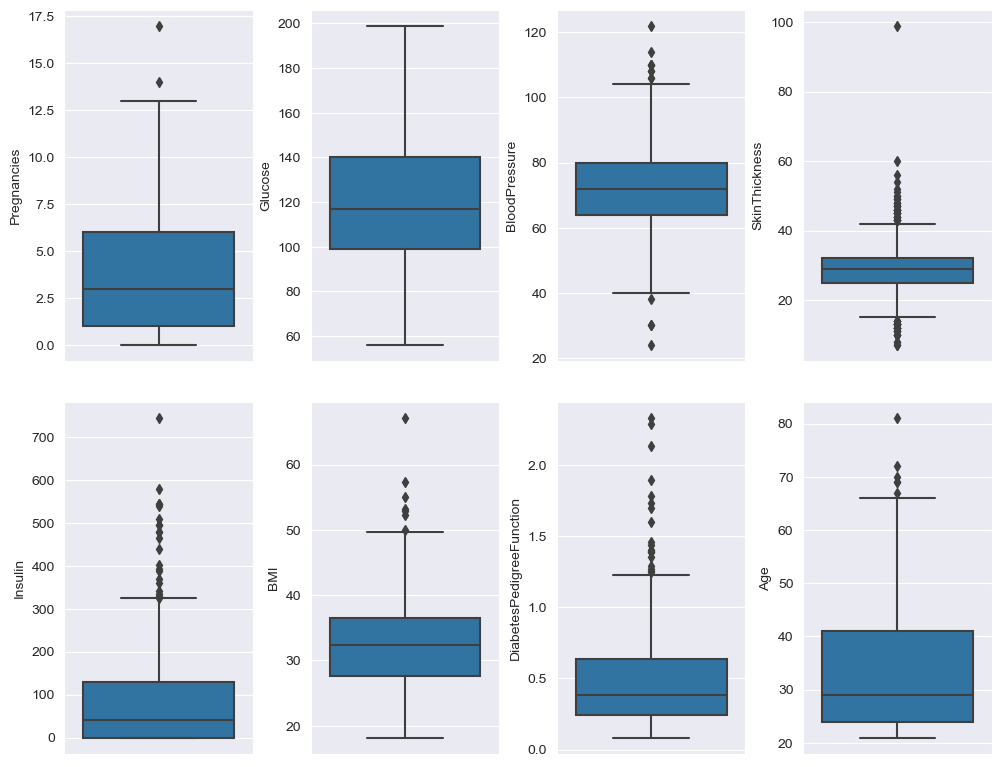

In [96]:
fig, graph = plt.subplots(2,4, figsize=(10,8))

plt.tight_layout()
for i,col in enumerate(numerical_cols):
    sns.boxplot(data=X_train, y=col, ax=graph[i//4][i%4])

## Outliers Treatment

In [97]:
X_train["Insulin"].describe()

count    614.000000
mean      78.666124
std      107.736572
min        0.000000
25%        0.000000
50%       40.500000
75%      130.000000
max      744.000000
Name: Insulin, dtype: float64

In [98]:
iiq = X_train["Insulin"].describe()["75%"] - X_train["Insulin"].describe()["25%"]
outlier_up= X_train["Insulin"].describe()["75%"] + 1.5 * iiq
outlier_down= X_train["Insulin"].describe()["25%"] - 1.5 * iiq
outlier_down, outlier_up

(-195.0, 325.0)

In [99]:
#X_train_without_outliers = X_train.loc[(X_train["Insulin"]>outlier_down) & (X_train["Insulin"]<outlier_up)]
#X_train_without_outliers.shape, X_train.shape, X_train.shape[0]-X_train_without_outliers.shape[0]

index = X_train.loc[(X_train["Insulin"]>outlier_down) & (X_train["Insulin"]<outlier_up)].index
X_train = X_train.loc[(X_train["Insulin"]>outlier_down) & (X_train["Insulin"]<outlier_up)]
y_train = y_train.loc[y_train.index.isin(index)]
X_train.shape, y_train.shape

((591, 8), (591, 1))

In [110]:
index = X_test.loc[(X_test["Insulin"]>outlier_down) & (X_test["Insulin"]<outlier_up)].index
X_test = X_test.loc[(X_test["Insulin"]>outlier_down) & (X_test["Insulin"]<outlier_up)]
y_test = y_test.loc[y_test.index.isin(index)]
X_test.shape, y_test.shape

((144, 8), (144, 1))

## Machine Learning with Cross Validation

In [100]:
kfold = StratifiedKFold(shuffle=True, n_splits=10, random_state=42)
scoring = 'accuracy'

def tomeklinks(X_, y_):
    tl = TomekLinks(sampling_strategy='majority')
    X_under, y_under = tl.fit_resample(X_,y_)
    return X_under, y_under    

def smote(X_, y_):
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_over, y_over = smote.fit_resample(X_,y_)
    return X_over, y_over

def getBestModelClassifier(X_, y_, sampling_technique=None):
    allowed_techniques = ['oversampling', 'undersampling', 'both',None]

    if sampling_technique not in allowed_techniques:
        raise ValueError(f"Invalid value for 'sampling_technique'. Choose from {allowed_techniques}.")
        
    selections = [
        ("NoSelection",None),
        ("SelectFdr",SelectFdr(score_func=f_classif)), 
        ("SelectFdr",SelectFpr(score_func=f_classif)), 
        ("Selectfwe",SelectFwe(score_func=f_classif))
    ]

    scalers = [
        ("NoScaler", None),
        ("MinMaxScaler", MinMaxScaler()),
        ("StandardScaler", StandardScaler()),
        ("Normalizer", Normalizer()),
        ("RobustScaler", RobustScaler())
    ]

    models = [
        ("LogisticRegression", LogisticRegression(random_state=42)),
        ("PassiveAggressiveClassifier", PassiveAggressiveClassifier(random_state=42)),
        ("SGDClassifier", SGDClassifier(random_state=42)),
        ("RidgeClassifier", RidgeClassifier(random_state=42)),
        ("SVC", SVC(random_state=42)),
        ("KNeighborsClassifier", KNeighborsClassifier()),
        ("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()),
        ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
        ("ExtraTreeClassifier", ExtraTreeClassifier(random_state=42)),
        ("GaussianNB", GaussianNB()),                
        #("GaussianProcessClassifier", GaussianProcessClassifier(random_state=42)),
        ("MLPClassifier", MLPClassifier(random_state=42))
    ]

    X_sampling_strategy = X_.copy()
    y_sampling_strategy = y_.copy()
    if sampling_technique == 'oversampling':
        X_sampling_strategy, y_sampling_strategy = smote(X_,y_)
    elif sampling_technique == 'undersampling':
        X_sampling_strategy, y_sampling_strategy = tomeklinks(X_,y_)
    elif sampling_technique == 'both':
        X_sampling_strategy, y_sampling_strategy = smote(X_,y_)
        X_sampling_strategy, y_sampling_strategy = tomeklinks(X_sampling_strategy, y_sampling_strategy)

    results = {}
    for name_scaler, scaler in scalers:
        for name_selection, selection in selections:
            for name_model, model in models:
                print (name_scaler, name_selection, name_model)
            
                pipeline = []
                if name_scaler != "NoScaler":
                    pipeline.append((name_scaler, scaler))
                if name_selection != "NoSelection":
                    pipeline.append((name_selection, selection))
                pipeline.append((name_model, model))
                
                estimator = Pipeline(pipeline)
                result = cross_val_score(estimator=estimator, X=X_sampling_strategy, y=y_sampling_strategy.values.flatten(), cv=kfold, scoring=scoring)
                results[name_scaler, name_selection, name_model] = result
                clear_output(wait=True)

    df_results = pd.DataFrame(results)
    for col in df_results.columns:
        if df_results[col].mean() == df_results.mean().max():
            print(f"Best: {col} with mean {df_results[col].mean()} (std={df_results[col].std()})")
    display(df_results.mean())

def getBestModelEnsembleClassifier(X_, y_, sampling_technique=None):
    allowed_techniques = ['oversampling', 'undersampling', "both",None]

    if sampling_technique not in allowed_techniques:
        raise ValueError(f"Invalid value for 'sampling_technique'. Choose from {allowed_techniques}.")

    selections = [
        ("NoSelection",None),
        ("SelectFdr",SelectFdr(score_func=f_classif)), 
        ("SelectFdr",SelectFpr(score_func=f_classif)), 
        ("Selectfwe",SelectFwe(score_func=f_classif))
    ]

    scalers = [
        ("NoScaler", None),
        ("MinMaxScaler", MinMaxScaler()),
        ("StandardScaler", StandardScaler()),
        ("Normalizer", Normalizer()),
        ("RobustScaler", RobustScaler())
    ]

    models = [
        ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=42)),
        ("ExtraTreeClassifier", ExtraTreeClassifier(random_state=42)),
        ("RandomForestClassifier", RandomForestClassifier(random_state=42)),
        ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=42)),
        ("AdaBoostClassifier", AdaBoostClassifier(random_state=42)),
        ("ExtraTreesClassifier", ExtraTreesClassifier(random_state=42)),
        ("BaggingClassifier", BaggingClassifier(random_state=42)),
        ("XGBClassifier", XGBClassifier(random_state=42))        
    ]

    X_sampling_strategy = X_.copy()
    y_sampling_strategy = y_.copy()
    if sampling_technique == 'oversampling':
        X_sampling_strategy, y_sampling_strategy = smote(X_,y_)
    elif sampling_technique == 'undersampling':
        X_sampling_strategy, y_sampling_strategy = tomeklinks(X_,y_)
    elif sampling_technique == 'both':
        X_sampling_strategy, y_sampling_strategy = smote(X_,y_)
        X_sampling_strategy, y_sampling_strategy = tomeklinks(X_sampling_strategy, y_sampling_strategy)

    results = {}
    for name_scaler, scaler in scalers:
        for name_selection, selection in selections:
            for name_model, model in models:
                print (name_scaler, name_selection, name_model)
            
                pipeline = []
                if name_scaler != "NoScaler":
                    pipeline.append((name_scaler, scaler))
                if name_selection != "NoSelection":
                    pipeline.append((name_selection, selection))
                pipeline.append((name_model, model))

                estimator = Pipeline(pipeline)
                result = cross_val_score(estimator=estimator, X=X_sampling_strategy, y=y_sampling_strategy.values.flatten(), cv=kfold, scoring=scoring)
                results[name_scaler, name_selection, name_model] = result
                clear_output(wait=True)

    df_results = pd.DataFrame(results)
    for col in df_results.columns:
        if df_results[col].mean() == df_results.mean().max():
            print(f"Best: {col} with mean {df_results[col].mean()} (std={df_results[col].std()})")
    display(df_results.mean())

In [101]:
getBestModelClassifier(X_train, y_train)

Best: ('MinMaxScaler', 'Selectfwe', 'MLPClassifier') with mean 0.7987288135593221 (std=0.043545452004146876)


NoScaler        NoSelection  LogisticRegression             0.788559
                             PassiveAggressiveClassifier    0.609011
                             SGDClassifier                  0.639605
                             RidgeClassifier                0.783475
                             SVC                            0.773305
                             KNeighborsClassifier           0.712486
                             LinearDiscriminantAnalysis     0.785169
                             DecisionTreeClassifier         0.692090
                             ExtraTreeClassifier            0.676893
                             GaussianNB                     0.756441
                             MLPClassifier                  0.727684
                SelectFdr    LogisticRegression             0.788559
                             PassiveAggressiveClassifier    0.609011
                             SGDClassifier                  0.639605
                             Ridge

In [102]:
getBestModelClassifier(X_train, y_train, sampling_technique='undersampling' )

Best: ('StandardScaler', 'Selectfwe', 'LogisticRegression') with mean 0.803668831168831 (std=0.03490223665037228)
Best: ('RobustScaler', 'Selectfwe', 'LogisticRegression') with mean 0.803668831168831 (std=0.03490223665037228)


NoScaler        NoSelection  LogisticRegression             0.794545
                             PassiveAggressiveClassifier    0.613994
                             SGDClassifier                  0.626753
                             RidgeClassifier                0.794708
                             SVC                            0.769448
                             KNeighborsClassifier           0.763864
                             LinearDiscriminantAnalysis     0.794708
                             DecisionTreeClassifier         0.720877
                             ExtraTreeClassifier            0.684773
                             GaussianNB                     0.762208
                             MLPClassifier                  0.722435
                SelectFdr    LogisticRegression             0.794545
                             PassiveAggressiveClassifier    0.613994
                             SGDClassifier                  0.626753
                             Ridge

In [103]:
getBestModelClassifier(X_train, y_train, sampling_technique="oversampling")

Best: ('StandardScaler', 'NoSelection', 'SVC') with mean 0.7991398896462187 (std=0.053019110093771096)
Best: ('StandardScaler', 'SelectFdr', 'SVC') with mean 0.7991398896462187 (std=0.053019110093771096)
Best: ('StandardScaler', 'Selectfwe', 'SVC') with mean 0.7991398896462187 (std=0.053019110093771096)


NoScaler        NoSelection  LogisticRegression             0.741626
                             PassiveAggressiveClassifier    0.570188
                             SGDClassifier                  0.571389
                             RidgeClassifier                0.750584
                             SVC                            0.739046
                             KNeighborsClassifier           0.763486
                             LinearDiscriminantAnalysis     0.749302
                             DecisionTreeClassifier         0.744352
                             ExtraTreeClassifier            0.734064
                             GaussianNB                     0.742941
                             MLPClassifier                  0.700795
                SelectFdr    LogisticRegression             0.741626
                             PassiveAggressiveClassifier    0.570188
                             SGDClassifier                  0.571389
                             Ridge

In [104]:
getBestModelClassifier(X_train, y_train, sampling_technique="both")

Best: ('StandardScaler', 'NoSelection', 'SVC') with mean 0.8059466848940533 (std=0.04151111296623044)
Best: ('StandardScaler', 'SelectFdr', 'SVC') with mean 0.8059466848940533 (std=0.04151111296623044)
Best: ('StandardScaler', 'Selectfwe', 'SVC') with mean 0.8059466848940533 (std=0.04151111296623044)


NoScaler        NoSelection  LogisticRegression             0.751230
                             PassiveAggressiveClassifier    0.585936
                             SGDClassifier                  0.605297
                             RidgeClassifier                0.744720
                             SVC                            0.738260
                             KNeighborsClassifier           0.772027
                             LinearDiscriminantAnalysis     0.744720
                             DecisionTreeClassifier         0.751299
                             ExtraTreeClassifier            0.714713
                             GaussianNB                     0.746070
                             MLPClassifier                  0.695215
                SelectFdr    LogisticRegression             0.751230
                             PassiveAggressiveClassifier    0.585936
                             SGDClassifier                  0.605297
                             Ridge

In [105]:
getBestModelEnsembleClassifier(X_train, y_train)

Best: ('NoScaler', 'Selectfwe', 'RandomForestClassifier') with mean 0.7614689265536724 (std=0.051144975992468894)
Best: ('RobustScaler', 'Selectfwe', 'RandomForestClassifier') with mean 0.7614689265536724 (std=0.051144975992468894)


NoScaler        NoSelection  DecisionTreeClassifier        0.692090
                             ExtraTreeClassifier           0.676893
                             RandomForestClassifier        0.754689
                             GradientBoostingClassifier    0.746356
                             AdaBoostClassifier            0.747938
                             ExtraTreesClassifier          0.744548
                             BaggingClassifier             0.748023
                             XGBClassifier                 0.724322
                SelectFdr    DecisionTreeClassifier        0.692090
                             ExtraTreeClassifier           0.676893
                             RandomForestClassifier        0.754689
                             GradientBoostingClassifier    0.746356
                             AdaBoostClassifier            0.747938
                             ExtraTreesClassifier          0.744548
                             BaggingClassifier  

In [106]:
getBestModelEnsembleClassifier(X_train, y_train, sampling_technique='undersampling')

Best: ('NoScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('NoScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('MinMaxScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('MinMaxScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('StandardScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('StandardScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('RobustScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)
Best: ('RobustScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.7893181818181818 (std=0.052371660744356924)


NoScaler        NoSelection  DecisionTreeClassifier        0.720877
                             ExtraTreeClassifier           0.684773
                             RandomForestClassifier        0.783766
                             GradientBoostingClassifier    0.762175
                             AdaBoostClassifier            0.762305
                             ExtraTreesClassifier          0.789318
                             BaggingClassifier             0.762240
                             XGBClassifier                 0.758604
                SelectFdr    DecisionTreeClassifier        0.720877
                             ExtraTreeClassifier           0.684773
                             RandomForestClassifier        0.783766
                             GradientBoostingClassifier    0.762175
                             AdaBoostClassifier            0.762305
                             ExtraTreesClassifier          0.789318
                             BaggingClassifier  

In [107]:
getBestModelEnsembleClassifier(X_train, y_train, sampling_technique="oversampling")

Best: ('NoScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('NoScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('NoScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('MinMaxScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('MinMaxScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('MinMaxScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('StandardScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('StandardScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8324732229795521 (std=0.054217758019160275)
Best: ('StandardScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.

NoScaler        NoSelection  DecisionTreeClassifier        0.744352
                             ExtraTreeClassifier           0.734064
                             RandomForestClassifier        0.824862
                             GradientBoostingClassifier    0.796624
                             AdaBoostClassifier            0.778773
                             ExtraTreesClassifier          0.832473
                             BaggingClassifier             0.776306
                             XGBClassifier                 0.812090
                SelectFdr    DecisionTreeClassifier        0.744352
                             ExtraTreeClassifier           0.734064
                             RandomForestClassifier        0.824862
                             GradientBoostingClassifier    0.796624
                             AdaBoostClassifier            0.778773
                             ExtraTreesClassifier          0.832473
                             BaggingClassifier  

In [108]:
getBestModelEnsembleClassifier(X_train, y_train, sampling_technique="both")

Best: ('NoScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('NoScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('NoScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('MinMaxScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('MinMaxScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('MinMaxScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('StandardScaler', 'NoSelection', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('StandardScaler', 'SelectFdr', 'ExtraTreesClassifier') with mean 0.8306561859193436 (std=0.047361414848516255)
Best: ('StandardScaler', 'Selectfwe', 'ExtraTreesClassifier') with mean 0.

NoScaler        NoSelection  DecisionTreeClassifier        0.751299
                             ExtraTreeClassifier           0.714713
                             RandomForestClassifier        0.808493
                             GradientBoostingClassifier    0.790226
                             AdaBoostClassifier            0.787731
                             ExtraTreesClassifier          0.830656
                             BaggingClassifier             0.801931
                             XGBClassifier                 0.801914
                SelectFdr    DecisionTreeClassifier        0.751299
                             ExtraTreeClassifier           0.714713
                             RandomForestClassifier        0.808493
                             GradientBoostingClassifier    0.790226
                             AdaBoostClassifier            0.787731
                             ExtraTreesClassifier          0.830656
                             BaggingClassifier  

### Oversampling

In [141]:
X_train_over, y_train_over = smote(X_train, y_train)

### Parameter Tuning

In [142]:
estimator = make_pipeline(StandardScaler(),ExtraTreesClassifier(random_state=42))
param_grid = dict(extratreesclassifier__criterion=['gini', 'entropy', 'log_loss'],
                  extratreesclassifier__n_estimators=[50,100,150,200,250,300, 350,400])
grid = GridSearchCV(estimator=estimator, cv=kfold, param_grid=param_grid, scoring=scoring)
grid_result = grid.fit(X_train_over, y_train_over.values.flatten())              
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} (stdev) with: {param}")

Best: 0.8324732229795522 using {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 100}
0.8312236286919832 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 50}
0.8324732229795522 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 100}
0.8299253489126908 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 150}
0.8299415774099318 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 200}
0.8286432976306394 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 250}
0.8299253489126907 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 300}
0.8286432976306395 (stdev) with: {'extratreesclassifier__criterion': 'gini', 'extratreesclassifier__n_estimators': 350}
0.8311911716975009 (stdev) with: {'extratre

### Feature Scaling

In [143]:
scaler = StandardScaler()
cols = X_train_over.columns
X_train_over_scaled = X_train_over.copy()
X_test_scaled = X_test.copy()

X_train_over_scaled[cols] = scaler.fit_transform(X_train_over)
X_test_scaled[cols] = scaler.transform(X_test)

## Champion Model Fit

In [157]:
model = ExtraTreesClassifier(random_state=42, criterion='gini', n_estimators=350) #350
model.fit(X_train_over_scaled, y_train_over)

ExtraTreesClassifier(n_estimators=350, random_state=42)

## Tests

In [158]:
pred = model.predict(X_test_scaled)
accuracy_score(y_test, pred), f1_score(y_test, pred)
#(0.75, 0.6538461538461539)

(0.75, 0.6538461538461539)

In [159]:
df_difference = pd.DataFrame({"real":y_test.values.flatten(),"pred":pred.flatten()})
df_difference["difference"] = abs(df_difference["real"] - df_difference["pred"])
df_difference.head(20)

,real,pred,difference
0,0,1,1
1,0,0,0
2,0,0,0
3,1,0,1
4,0,0,0
5,0,1,1
6,1,0,1
7,1,1,0
8,0,0,0
9,0,1,1


In [160]:
cm = confusion_matrix(y_test,pred)
cm

array([[74, 20],
       [16, 34]], dtype=int64)

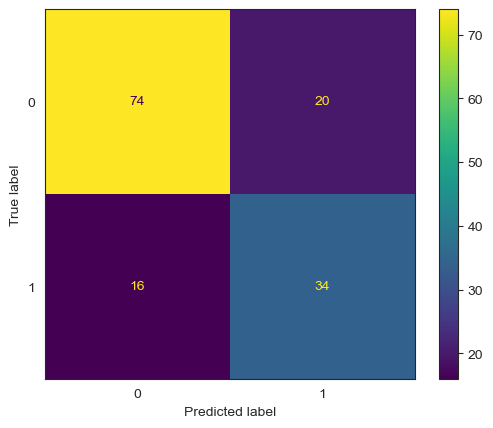

In [161]:
sns.set_style("white")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [162]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80        94
           1       0.63      0.68      0.65        50

    accuracy                           0.75       144
   macro avg       0.73      0.73      0.73       144
weighted avg       0.76      0.75      0.75       144

